In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

**Data preparation**

In [2]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=30)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=30)
test_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=30)

Found 202 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


**Download Model VGG16**

In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

# use “get_layer” method to save the last layer of the network
# save the output of the last layer to be the input of the next layer
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add FC layer, which has 64 units and relu activation 
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# add our new softmax layer with 2 hidden units
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_2 (Dense)                         │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,320,770 (62.26 MB)

 Trainable params: 1,605,954 (6.13 MB)

 Non-trainable params: 14,714,816 (56.13 MB)

In [7]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

**accuracy without training**

In [8]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

C:\Users\PaulE\DeepLearning\local\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5470 - loss: 7.0560
Test Loss: 7.440826892852783
Test Accuracy: 0.5377777814865112


In [9]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='cats_dogs.model.keras', save_best_only=True)

history = new_model.fit(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=20, verbose=2, callbacks=[checkpointer])

Epoch 1/20
4/4 - 15s - 4s/step - accuracy: 0.6339 - loss: 0.7733 - val_accuracy: 0.7833 - val_loss: 1.1503
Epoch 2/20


C:\Users\PaulE\DeepLearning\local\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 - 12s - 3s/step - accuracy: 0.7778 - loss: 0.5056 - val_accuracy: 0.8833 - val_loss: 0.5555
Epoch 3/20
4/4 - 14s - 3s/step - accuracy: 0.9417 - loss: 0.1673 - val_accuracy: 0.9333 - val_loss: 0.2581
Epoch 4/20
4/4 - 12s - 3s/step - accuracy: 0.9024 - loss: 0.1937 - val_accuracy: 0.8833 - val_loss: 0.2319
Epoch 5/20
4/4 - 14s - 4s/step - accuracy: 0.9821 - loss: 0.0690 - val_accuracy: 0.9167 - val_loss: 0.2131
Epoch 6/20
4/4 - 12s - 3s/step - accuracy: 0.9444 - loss: 0.1103 - val_accuracy: 0.9333 - val_loss: 0.1645
Epoch 7/20
4/4 - 14s - 4s/step - accuracy: 0.9917 - loss: 0.0463 - val_accuracy: 0.9500 - val_loss: 0.1893
Epoch 8/20
4/4 - 11s - 3s/step - accuracy: 0.9878 - loss: 0.0290 - val_accuracy: 0.9167 - val_loss: 0.1932
Epoch 9/20
4/4 - 13s - 3s/step - accuracy: 0.9911 - loss: 0.0324 - val_accuracy: 0.9000 - val_loss: 0.2605
Epoch 10/20
4/4 - 12s - 3s/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9500 - val_loss: 0.1556
Epoch 11/20
4/4 - 15s - 4s/step - accuracy: 0.9

In [10]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9720 - loss: 0.0805
Test Loss: 0.10346682369709015
Test Accuracy: 0.9666666388511658


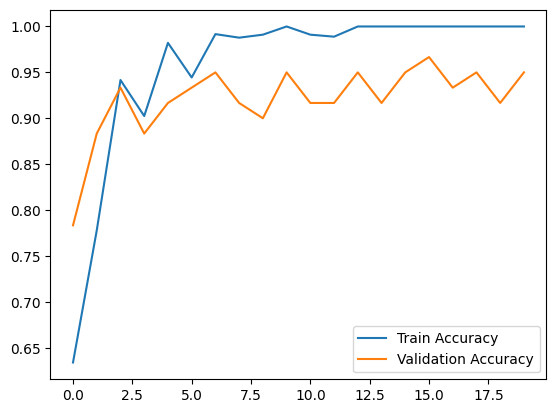

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

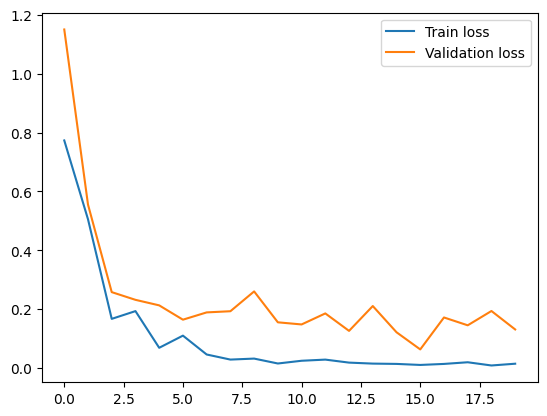

In [12]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

**Train with some features layers**

In [13]:
for layer in base_model.layers[:-5]:
    layer.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True
    
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add FC layer, which has 64 units and relu activation 
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# add our new softmax layer with 2 hidden units
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model_2 = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_2 (Dense)                         │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,320,770 (62.26 MB)

 Trainable params: 8,685,378 (33.13 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [14]:
new_model_2.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint

checkpointer2 = ModelCheckpoint(filepath='cats_dogs_with_retrain.model.keras', save_best_only=True)

history2 = new_model_2.fit(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=20, verbose=2, callbacks=[checkpointer2])

Epoch 1/20
4/4 - 20s - 5s/step - accuracy: 0.6583 - loss: 0.8601 - val_accuracy: 0.7667 - val_loss: 1.5178
Epoch 2/20
4/4 - 14s - 3s/step - accuracy: 0.8659 - loss: 0.2892 - val_accuracy: 0.8500 - val_loss: 0.5602
Epoch 3/20
4/4 - 17s - 4s/step - accuracy: 0.9375 - loss: 0.1807 - val_accuracy: 0.9500 - val_loss: 0.1884
Epoch 4/20
4/4 - 14s - 3s/step - accuracy: 0.9444 - loss: 0.1160 - val_accuracy: 0.9167 - val_loss: 0.2672
Epoch 5/20
4/4 - 16s - 4s/step - accuracy: 0.9732 - loss: 0.0828 - val_accuracy: 0.9167 - val_loss: 0.2448
Epoch 6/20
4/4 - 14s - 3s/step - accuracy: 0.9889 - loss: 0.0309 - val_accuracy: 0.9000 - val_loss: 0.3141
Epoch 7/20
4/4 - 16s - 4s/step - accuracy: 0.9911 - loss: 0.0406 - val_accuracy: 0.8667 - val_loss: 0.4338
Epoch 8/20
4/4 - 13s - 3s/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.8833 - val_loss: 0.3672
Epoch 9/20
4/4 - 16s - 4s/step - accuracy: 0.9911 - loss: 0.0325 - val_accuracy: 0.9333 - val_loss: 0.1567
Epoch 10/20
4/4 - 14s - 3s/step - acc

In [18]:
test_loss, test_accuracy = new_model_2.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9695 - loss: 0.1183
Test Loss: 0.10665936022996902
Test Accuracy: 0.9622222185134888


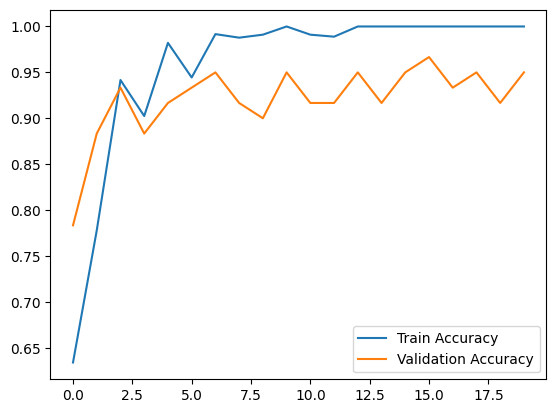

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

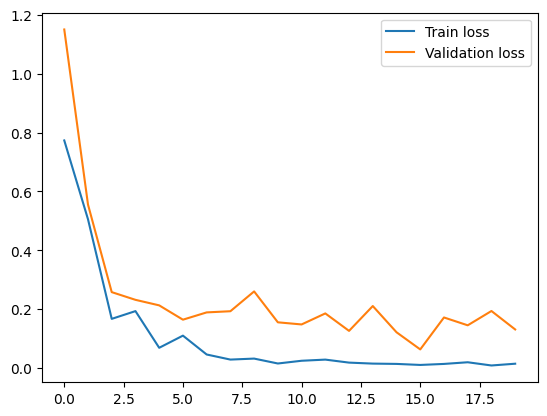

In [20]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()